# Multistage mixer-settlers

Liquid-liquid extraction takes advantage of chemical interactions within a mixture to selectively recover (or remove) a solute using a solvent. In the context of fermentation product recovery, oleochemicals can be recovered using a hydrophobic solvent. Another classic example is biodiesel "washing", where water is used to recover glycerol and unreacted alcohols from crude biodiesel. After extraction, the solvent (typically a more volatile component with a low heat of vaporization) is generally distilled and recycled.

The recovery and concentration of the solute (in the solvent) will depend on how much solvent is used. More solvent can lead to higher recoveries but at lower concentrations (which increases expenses associated to solvent recovery). Counter-current multistage liquid extraction (employing 2 or more stages) can increase the recovery and improve the attainable concentration of the product, but at the expence of higher capital costs. Therefore, we have a trade-off between the recovery efficiency and capital/operating expenses as a function of solvent usage and number of stages. 

In this tutorial we will model the recovery of octanol (a medium-chain fatty alcohol) from a fementation broth using multistage mixer-settlers. We will also push and pull the model to quantify the trade-off between recovery and concentration as a function of design decisions.

Let's start by simulating the multistage mixer-settler assuming 2 stages and an equal volume of solvent.

In [1]:
import biosteam as bst
bst.nbtutorial()
bst.settings.set_thermo(['Water', 'Hexane', 'Hexanol'])
feed = bst.Stream('feed', Water=96, Hexanol=4, units='m3/hr') 
solvent = bst.Stream('solvent', Hexane=100, units='m3/hr')
mixer_settlers = bst.MultiStageMixerSettlers(
    'mixer_settlers',
    ins=(feed, solvent), 
    outs=('extract', 'raffinate'), 
    N_stages=2,
    use_cache=True,
)
mixer_settlers.simulate()
mixer_settlers.show()

MultiStageMixerSettlers: mixer_settlers
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water    5.31e+03
                    Hexanol  31.9
[1] solvent  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Hexane  760
outs...
[0] extract  
    phase: 'L', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water    11.3
                    Hexane   759
                    Hexanol  30.7
[1] raffinate  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water    5.3e+03
                    Hexane   0.806
                    Hexanol  1.22


The recovery is high (>99%) even at just 2 stages. This means it may be possible to reduce the solvent use substantially. Let's have a look at the tradeoff in concentration as a function of solvent usage and number of stages.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation function
def concentration_recovery_capital_cost(solvent_usage, N_stages):
    solvent.F_vol = feed.F_vol * solvent_usage
    mixer_settlers.N_stages = N_stages
    mixer_settlers.simulate()
    extract = mixer_settlers.extract
    recovery = 100 * extract.imol['Hexanol'] / feed.imol['Hexanol'] # %
    concentration = extract.imass['Hexanol'] / extract.F_vol # kg / m3
    capital_cost = mixer_settlers.installed_cost / 1e3
    return (recovery, concentration, capital_cost)

# Collect data
N_stages = [2, 5, 10]
solvent_usage = np.linspace(0.2, 1, 20) # Solvent to feed flow rate (by volume)
shape = (len(N_stages), len(solvent_usage))
recoveries = np.zeros(shape)
concentrations = np.zeros(shape)
capital_costs = np.zeros(shape)
for i, N in enumerate(N_stages):
    for j, s in enumerate(solvent_usage):
        recoveries[i, j], concentrations[i, j], capital_costs[i, j] = concentration_recovery_capital_cost(s, N)

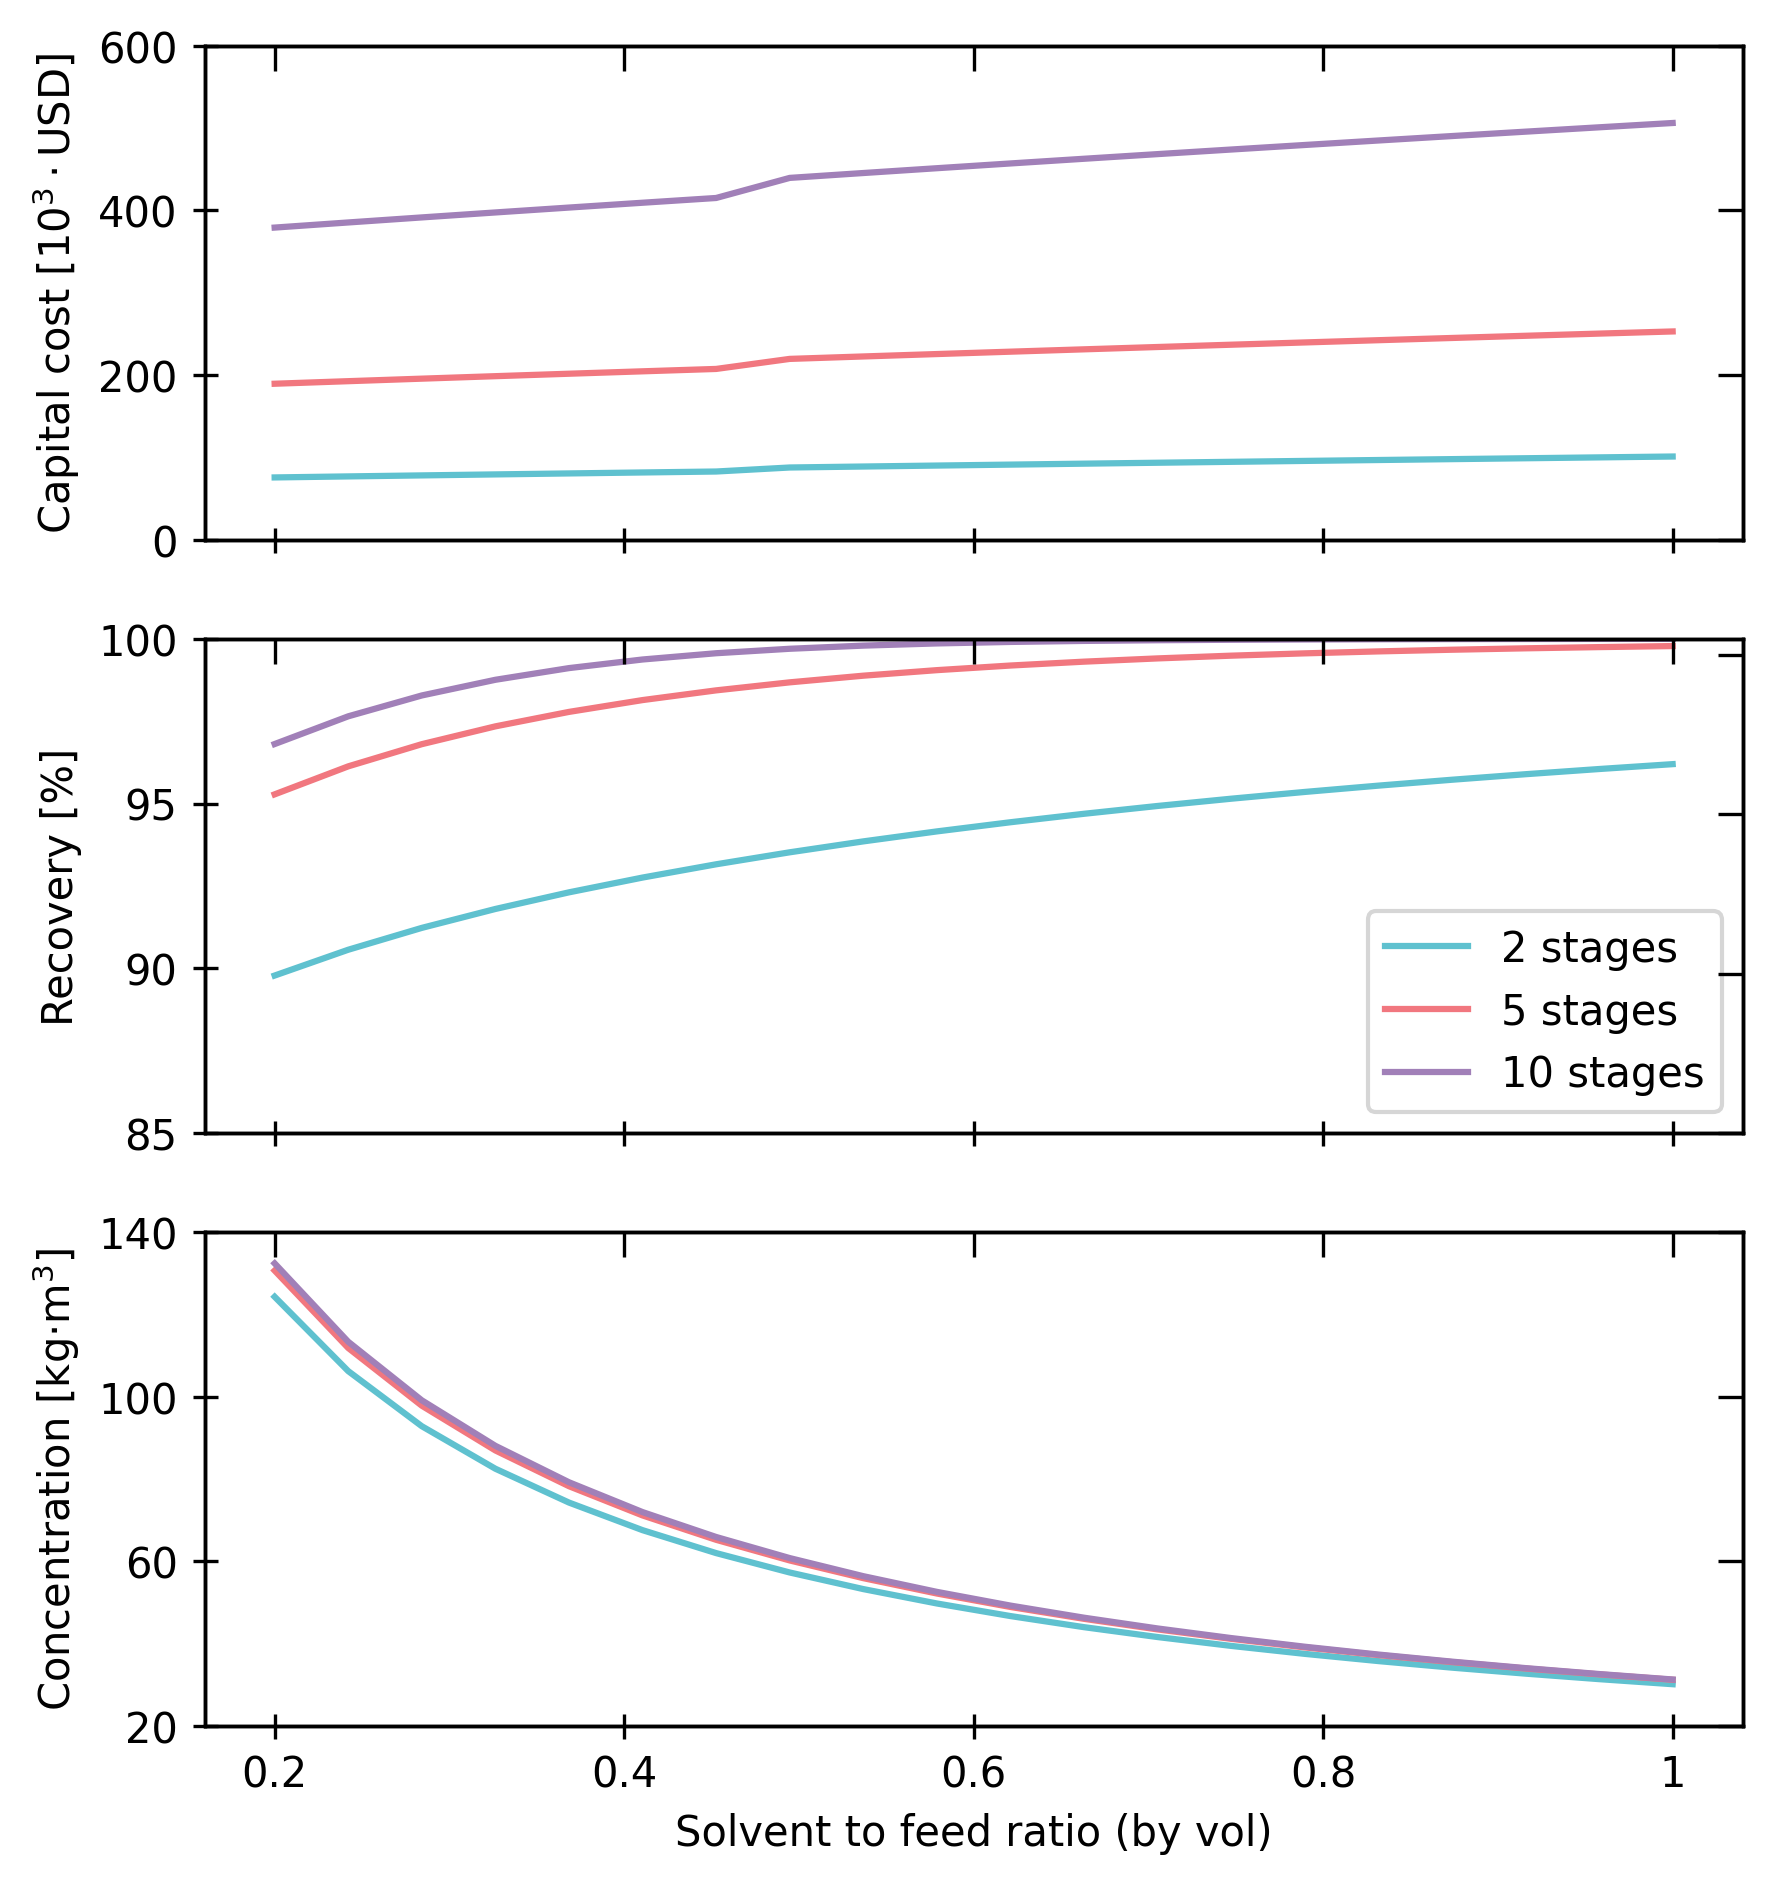

In [8]:
# Plot
bst.set_figure_size(aspect_ratio=1.1)
colors = [getattr(bst.colors, i).RGBn for i in ('blue', 'red', 'purple')]
fig, (ax_capex, ax_recovery, ax_concentration) = plt.subplots(3, 1)
for i, N in enumerate(N_stages):
    plt.sca(ax_capex)
    plt.plot(solvent_usage, capital_costs[i], color=colors[i], label=f'{N} stages')
    plt.sca(ax_recovery)
    plt.plot(solvent_usage, recoveries[i], color=colors[i], label=f'{N} stages')
    plt.sca(ax_concentration)
    plt.plot(solvent_usage, concentrations[i], color=colors[i], label=f'{N} stages')
xticks = [0.2, 0.4, 0.6, 0.8, 1]
bst.style_axis(ax_capex, yticks=[0, 200, 400, 600], xticks=xticks, xticklabels=False)
plt.sca(ax_capex)
plt.ylabel('Capital cost [10$^3 \cdot$USD]')

bst.style_axis(ax_recovery, yticks=[85, 90, 95, 100], xticks=xticks, xticklabels=False)
plt.sca(ax_recovery)
plt.ylabel('Recovery [%]')
plt.ylim([85, 100])
plt.legend()

bst.style_axis(ax_concentration, yticks=[20, 60, 100, 140], xticks=xticks)
plt.sca(ax_concentration)
plt.ylabel('Concentration [kg$\cdot$m$^3$]')
plt.xlabel('Solvent to feed ratio (by vol)')
plt.show()

Note how there is a trade-off between solute concentration in the extract and recovery as a function of solvent. Increasing the number of stages may improve the recovery, but can lead to greater capital costs.